In [14]:
## Importing required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import normalize

import warnings

from subprocess import check_output
print(check_output(["ls", "inputs"]).decode("utf8"))

database.sqlite



In [15]:
start = time()
## Fetching data
#Connecting to database
path = "inputs/"
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

#Fetching required data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
# 21518 spanish La Liga
match_data = pd.read_sql("SELECT * FROM Match WHERE league_id = 21518;", conn)

match_data.head(10)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,21518,21518,21518,2008/2009,1,2008-08-30 00:00:00,530023,10267,8661,3,...,5.00,1.65,3.40,4.50,1.75,3.30,5.00,1.67,3.40,5.00
1,21519,21518,21518,2008/2009,1,2008-08-31 00:00:00,530084,8371,10205,1,...,2.60,2.90,3.20,2.25,2.75,3.20,2.50,2.80,3.25,2.30
2,21520,21518,21518,2008/2009,1,2008-08-31 00:00:00,530085,9783,8633,2,...,1.90,3.25,3.25,2.00,3.50,3.20,2.10,3.25,3.25,2.10
3,21521,21518,21518,2008/2009,1,2008-08-31 00:00:00,530086,8388,8634,1,...,1.57,7.00,3.75,1.45,6.50,3.75,1.53,5.50,3.75,1.53
4,21522,21518,21518,2008/2009,1,2008-08-31 00:00:00,530087,8696,8302,1,...,2.30,2.70,3.10,2.40,2.75,3.25,2.45,2.70,3.25,2.38
5,21523,21518,21518,2008/2009,1,2008-08-31 00:00:00,530088,9869,8305,1,...,2.70,2.50,3.10,2.65,2.50,3.20,2.75,2.60,3.20,2.40
6,21524,21518,21518,2008/2009,1,2008-08-31 00:00:00,530089,8603,8479,0,...,4.50,1.75,3.25,4.35,1.95,3.20,4.00,1.73,3.30,4.50
7,21525,21518,21518,2008/2009,1,2008-08-30 00:00:00,530090,8558,10281,1,...,4.00,1.90,3.25,3.50,2.00,3.20,3.75,1.80,3.25,4.33
8,21526,21518,21518,2008/2009,1,2008-08-31 00:00:00,530091,8315,9865,1,...,4.00,1.90,3.20,3.60,2.00,3.20,3.75,1.91,3.25,3.75
9,21527,21518,21518,2008/2009,1,2008-08-31 00:00:00,530092,9906,9864,4,...,9.00,1.45,3.75,7.00,1.50,3.60,7.50,1.50,3.75,6.00


In [16]:
# Only interesting columns, include BWIN betting odds
matches = match_data[match_data.columns[:11]].join(match_data[match_data.columns[88:91]])
teams = team_data

# Add team names & tidy up
matches = pd.merge(left=matches, right=teams, how='left', left_on='home_team_api_id', right_on='team_api_id')
matches = matches.drop(['country_id','league_id', 'home_team_api_id', 'id_y', 'team_api_id', 'team_short_name'], axis=1)
matches.rename(columns={'id_x':'match_id', 'team_long_name':'home_team'}, inplace=True)
matches = pd.merge(left=matches, right=teams, how='left', left_on='away_team_api_id', right_on='team_api_id')
matches = matches.drop(['id', 'match_api_id', 'away_team_api_id','team_api_id', 'team_short_name','team_fifa_api_id_x','team_fifa_api_id_y'], axis=1)
matches.rename(columns={'id_x':'match_id', 'team_long_name':'away_team'}, inplace=True)

matches.tail()

,match_id,season,stage,date,home_team_goal,away_team_goal,BWH,BWD,BWA,home_team,away_team
3035,24553,2015/2016,9,2015-10-25 00:00:00,2,1,1.57,4.00,6.5,Atlético Madrid,Valencia CF
3036,24554,2015/2016,9,2015-10-24 00:00:00,2,0,2.35,3.10,3.1,Málaga CF,RC Deportivo de La Coruña
3037,24555,2015/2016,9,2015-10-26 00:00:00,3,0,1.55,4.00,6.5,Athletic Club de Bilbao,Real Sporting de Gijón
3038,24556,2015/2016,9,2015-10-24 00:00:00,1,1,2.35,3.25,3.0,Granada CF,Real Betis Balompié
3039,24557,2015/2016,9,2015-10-23 00:00:00,3,0,2.25,3.50,3.2,Rayo Vallecano,RCD Espanyol


In [17]:
# Sort matches by stage numerically, not by string
full_matches=matches
full_matches['stage'] = full_matches['stage'].apply(pd.to_numeric, errors='coerce')

full_matches.sort_values(by='stage', inplace=True)
full_matches.head(15)

,match_id,season,stage,date,home_team_goal,away_team_goal,BWH,BWD,BWA,home_team,away_team
0,21518,2008/2009,1,2008-08-30 00:00:00,3,0,1.65,3.35,5.00,Valencia CF,RCD Mallorca
1527,23045,2012/2013,1,2012-08-18 00:00:00,2,1,2.00,3.30,4.10,RCD Mallorca,RCD Espanyol
1526,23044,2012/2013,1,2012-08-18 00:00:00,0,1,2.25,3.40,3.25,RC Celta de Vigo,Málaga CF
1525,23043,2012/2013,1,2012-08-20 00:00:00,0,1,2.05,3.30,3.60,Real Zaragoza,Real Valladolid
1524,23042,2012/2013,1,2012-08-19 00:00:00,1,1,3.10,3.40,2.30,Levante UD,Atlético Madrid
1523,23041,2012/2013,1,2012-08-18 00:00:00,2,1,1.60,3.75,5.50,Sevilla FC,Getafe CF
1522,23040,2012/2013,1,2012-08-19 00:00:00,5,1,1.08,10.00,23.00,FC Barcelona,Real Sociedad
1521,23039,2012/2013,1,2012-08-19 00:00:00,1,1,1.26,5.75,9.75,Real Madrid CF,Valencia CF
1520,23038,2012/2013,1,2012-08-19 00:00:00,3,5,1.85,3.50,4.10,Athletic Club de Bilbao,Real Betis Balompié
1149,22667,2011/2012,1,2012-01-22 00:00:00,0,1,2.05,3.25,3.60,Rayo Vallecano,RCD Mallorca


In [18]:
# Functions for feature generation
from collections import defaultdict
import operator


def game_result(match):
    if match['home_team_goal'] > match['away_team_goal']:
        return 'win'
    elif match['home_team_goal'] < match['away_team_goal']:
        return 'lose'
    else:
        return 'draw'

# - wins/draws/losses til date in season
# - strike of wins/draws/losses til date in season
# - position in league
# - goals favor/against til date in season
# - avg goals per game favor/against til date in season
# - ...
def initialize_season_stats(season_stats,teams):
    for team in teams:
        season_stats[0][team] = {'w_til_date': 0, 'd_til_date': 0, 'l_til_date': 0,
                                  'strike_w_til_date': 0,'strike_d_til_date': 0,'strike_l_til_date': 0,
                                  'points': 0,
                                  'pos': 0,'goals_favor_til_date': 0,'goals_against_til_date': 0,
                                  'avg_goals_favor_til_date': 0, 'avg_goals_against_til_date': 0}

def update_season_stats(season_stats,game):
    prev_stage = game.stage-1
    home_team = game['home_team']
    away_team = game['away_team']
    season_stats[game.stage][home_team] = season_stats[prev_stage][home_team].copy()
    season_stats[game.stage][away_team] = season_stats[prev_stage][away_team].copy()
    # Add results, strikes and points
    result = game_result(game)
    if result == "win":
        #Points
        season_stats[game.stage][home_team]['points'] += 3
        #Results
        season_stats[game.stage][home_team]['w_til_date'] += 1
        season_stats[game.stage][away_team]['l_til_date'] += 1
        #Strikes
        season_stats[game.stage][home_team]['strike_w_til_date'] += 1
        season_stats[game.stage][home_team]['strike_d_til_date'] = 0
        season_stats[game.stage][home_team]['strike_l_til_date'] = 0
        season_stats[game.stage][away_team]['strike_w_til_date'] = 0
        season_stats[game.stage][away_team]['strike_d_til_date'] = 0
        season_stats[game.stage][away_team]['strike_l_til_date'] += 1
    elif result == "draw":
        #Points
        season_stats[game.stage][home_team]['points'] += 1
        season_stats[game.stage][away_team]['points'] += 1
        #Results
        season_stats[game.stage][home_team]['d_til_date'] += 1
        season_stats[game.stage][away_team]['d_til_date'] += 1
        #Strikes
        season_stats[game.stage][home_team]['strike_w_til_date'] = 0
        season_stats[game.stage][home_team]['strike_d_til_date'] +=1
        season_stats[game.stage][home_team]['strike_l_til_date'] = 0
        season_stats[game.stage][away_team]['strike_w_til_date'] = 0
        season_stats[game.stage][away_team]['strike_d_til_date'] += 1
        season_stats[game.stage][away_team]['strike_l_til_date'] = 0
    elif result == "lose":
        #Points
        season_stats[game.stage][away_team]['points'] += 3
        #Results
        season_stats[game.stage][home_team]['l_til_date'] += 1
        season_stats[game.stage][away_team]['w_til_date'] += 1
        #Strikes
        season_stats[game.stage][home_team]['strike_w_til_date'] = 0
        season_stats[game.stage][home_team]['strike_d_til_date'] = 0
        season_stats[game.stage][home_team]['strike_l_til_date'] += 1
        season_stats[game.stage][away_team]['strike_w_til_date'] += 1
        season_stats[game.stage][away_team]['strike_d_til_date'] = 0
        season_stats[game.stage][away_team]['strike_l_til_date'] = 0
    # Add goals and avg
    season_stats[game.stage][home_team]['goals_favor_til_date'] = season_stats[prev_stage][home_team]['goals_favor_til_date'] + game['home_team_goal']
    season_stats[game.stage][away_team]['goals_favor_til_date'] = season_stats[prev_stage][away_team]['goals_favor_til_date'] + game['away_team_goal']
    season_stats[game.stage][home_team]['goals_against_til_date'] = season_stats[prev_stage][home_team]['goals_against_til_date'] + game['away_team_goal']
    season_stats[game.stage][away_team]['goals_against_til_date'] = season_stats[prev_stage][away_team]['goals_against_til_date'] + game['home_team_goal']
    
    season_stats[game.stage][home_team]['avg_goals_favor_til_date'] = season_stats[game.stage][home_team]['goals_favor_til_date'] / game.stage
    season_stats[game.stage][away_team]['avg_goals_favor_til_date'] = season_stats[game.stage][away_team]['goals_favor_til_date'] / game.stage
    season_stats[game.stage][home_team]['avg_goals_against_til_date'] = season_stats[game.stage][home_team]['goals_against_til_date'] / game.stage
    season_stats[game.stage][away_team]['avg_goals_against_til_date'] = season_stats[game.stage][away_team]['goals_against_til_date'] / game.stage
    
        
def set_position_in_league(season_stats,stage):
    prev_stage = stage-1
    sorted_teams = sorted(season_stats[prev_stage].items(), key=lambda y: y[1]['points'])
    for pos,team in enumerate(sorted_teams):
        season_stats[prev_stage][team[0]]['pos'] = pos

# Create a dictionary containing snapshots of the status in each stage
def create_season_stage_stats_til_date(games):
    print("Generating features...")
    stats = defaultdict(dict)
    for season in games.season.unique():
        games_in_season = games[games['season'] == season]
        teams_in_season = games_in_season.home_team.unique()
        season_stats = defaultdict(lambda: defaultdict(dict))
        for stage in games_in_season.stage.unique():
            if stage == 1:
                initialize_season_stats(season_stats,teams_in_season)
            else:
                games_in_previous_stage = games_in_season[games_in_season['stage'] == (stage-1)]
                for i,game in games_in_previous_stage.iterrows():
                    update_season_stats(season_stats,game)
                # Add pos
                set_position_in_league(season_stats,stage)
        stats[season] = season_stats
    print("Done generating features...")
    return stats
    
season_stage_stats_per_team = create_season_stage_stats_til_date(full_matches)

Generating features...
Done generating features...


In [19]:
# Convert home/away & team into a binary feature, ie 'Real Madrid_h' or 'Real Madrid_a'
full_match_team_features = pd.DataFrame(full_matches[['season', 'stage','home_team','away_team','home_team_goal','away_team_goal','BWH','BWD', 'BWA']],
                                   columns=[['season', 'stage','home_team','away_team','home_team_goal','away_team_goal','BWH','BWD', 'BWA']])

full_match_team_features = pd.concat([full_match_team_features, pd.get_dummies(full_matches['home_team']).rename(columns=lambda x: str(x) + '_h')],
                                axis=1)
full_match_team_features = pd.concat([full_match_team_features, pd.get_dummies(full_matches['away_team']).rename(columns=lambda x: str(x) + '_a')],
                         axis=1)


# Function to determine whether result is a win/draw/lose
def determine_home_result(match):
    if match['home_team_goal'] > match['away_team_goal']:
        return 'win'
    elif match['home_team_goal'] < match['away_team_goal']:
        return 'lose'
    else:
        return 'draw'

# Function to determine whether bwin predicted a win/draw/lose
def determine_bwin_result(match):
    if (match['BWH'] < match['BWD']) and (match['BWH'] < match['BWA']):
        return 'win'
    elif (match['BWA'] < match['BWH']) and (match['BWA'] < match['BWD']):
        return 'lose'
    else:
        return 'draw'

#  Add the home team result column
full_match_team_features['home_team_result'] = full_match_team_features.apply(determine_home_result, axis=1)
full_match_team_features.tail()

#  Add betting target label
full_match_team_features['BWIN_home_predict'] = full_match_team_features.apply(determine_bwin_result, axis=1)
full_match_team_features = full_match_team_features.drop(['BWH','BWD', 'BWA'], axis=1)
full_match_team_features.tail(10)

,season,stage,home_team,away_team,home_team_goal,away_team_goal,Athletic Club de Bilbao_h,Atlético Madrid_h,CA Osasuna_h,CD Numancia_h,...,Real Zaragoza_a,SD Eibar_a,Sevilla FC_a,UD Almería_a,UD Las Palmas_a,Valencia CF_a,Villarreal CF_a,Xerez Club Deportivo_a,home_team_result,BWIN_home_predict
693,2009/2010,38,UD Almería,Sevilla FC,2,3,0,0,0,0,...,0,0,1,0,0,0,0,0,lose,lose
316,2008/2009,38,RC Deportivo de La Coruña,FC Barcelona,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,draw,win
314,2008/2009,38,Racing Santander,Getafe CF,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,draw,lose
313,2008/2009,38,Real Sporting de Gijón,RC Recreativo,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,win,win
312,2008/2009,38,RCD Espanyol,Málaga CF,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,win,win
311,2008/2009,38,Atlético Madrid,UD Almería,3,0,0,1,0,0,...,0,0,0,1,0,0,0,0,win,win
310,2008/2009,38,Valencia CF,Athletic Club de Bilbao,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,win,win
2210,2013/2014,38,Málaga CF,Levante UD,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,win,win
315,2008/2009,38,CD Numancia,Sevilla FC,0,2,0,0,0,1,...,0,0,1,0,0,0,0,0,lose,lose
698,2009/2010,38,Athletic Club de Bilbao,RC Deportivo de La Coruña,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,win,win


In [20]:
# Analyze results and bwin predictions
print(full_match_team_features['home_team_result'].value_counts())
full_match_team_features['BWIN_home_predict'].value_counts()

win     1485
lose     851
draw     704
Name: home_team_result, dtype: int64


win     2258
lose     759
draw      23
Name: BWIN_home_predict, dtype: int64

In [21]:
# Add match features based on the computed season/stage/team state dictionary 'season_stage_stats_per_team'

def add_features_for_team(row,away_or_home_str):
    team_stats=season_stage_stats_per_team[row.season][row.stage-1][row[away_or_home_str]]
    row[away_or_home_str+'_w_til_date']=team_stats['w_til_date']
    row[away_or_home_str+'_d_til_date']=team_stats['d_til_date']
    row[away_or_home_str+'_l_til_date']=team_stats['l_til_date']
    row[away_or_home_str+'_strike_w_til_date']=team_stats['strike_w_til_date']
    row[away_or_home_str+'_strike_d_til_date']=team_stats['strike_d_til_date']
    row[away_or_home_str+'_points']=team_stats['points']
    row[away_or_home_str+'_pos']=team_stats['pos']
    row[away_or_home_str+'_goals_favor_til_date']=team_stats['goals_favor_til_date']
    row[away_or_home_str+'_goals_against_til_date']=team_stats['goals_against_til_date']
    row[away_or_home_str+'_avg_goals_favor_til_date']=team_stats['avg_goals_favor_til_date']
    row[away_or_home_str+'_avg_goals_against_til_date']=team_stats['avg_goals_against_til_date']
    
    

def add_match_features(row):
    for t in ['home_team','away_team']:
        add_features_for_team(row,t)
    row['pos_diff']=row['home_team_pos']-row['away_team_pos']
    row['points_diff']=row['home_team_points']-row['away_team_points']
    return row
    

full_match_features_final = full_match_team_features.apply(add_match_features, axis=1)
full_match_features_final.tail(30)

,season,stage,home_team,away_team,home_team_goal,away_team_goal,Athletic Club de Bilbao_h,Atlético Madrid_h,CA Osasuna_h,CD Numancia_h,...,away_team_strike_w_til_date,away_team_strike_d_til_date,away_team_points,away_team_pos,away_team_goals_favor_til_date,away_team_goals_against_til_date,away_team_avg_goals_favor_til_date,away_team_avg_goals_against_til_date,pos_diff,points_diff
2594,2014/2015,38,Rayo Vallecano,Real Sociedad,2,4,0,0,0,0,...,0,0,43,8,40,49,1.081081,1.324324,3,6
2593,2014/2015,38,Granada CF,Atlético Madrid,0,0,0,0,0,0,...,0,0,77,17,67,29,1.810811,0.783784,-14,-43
2592,2014/2015,38,FC Barcelona,RC Deportivo de La Coruña,2,2,0,0,0,0,...,1,0,34,4,33,58,0.891892,1.567568,15,59
2591,2014/2015,38,Levante UD,Elche CF,0,0,0,0,0,0,...,0,0,40,7,35,62,0.945946,1.675676,-2,-4
2590,2014/2015,38,Athletic Club de Bilbao,Villarreal CF,4,0,1,0,0,0,...,2,0,60,14,48,33,1.297297,0.891892,-1,-8
2219,2013/2014,38,Valencia CF,RC Celta de Vigo,2,1,0,0,0,0,...,4,0,49,12,48,52,1.297297,1.405405,-2,-3
2218,2013/2014,38,Real Madrid CF,RCD Espanyol,3,1,0,0,0,0,...,0,1,42,7,40,48,1.081081,1.297297,10,42
2217,2013/2014,38,CA Osasuna,Real Betis Balompié,2,1,0,0,1,0,...,1,0,25,0,35,76,0.945946,2.054054,1,11
2216,2013/2014,38,Real Valladolid,Granada CF,0,1,0,0,0,0,...,0,0,38,3,31,56,0.837838,1.513514,-1,-2
2215,2013/2014,38,UD Almería,Athletic Club de Bilbao,0,0,0,0,0,0,...,0,1,69,16,66,39,1.783784,1.054054,-12,-30


In [22]:
# ML

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score


features = full_match_features_final.drop(['season','home_team','away_team','pos_diff','points_diff','home_team_result','home_team_goal','away_team_goal','BWIN_home_predict'], axis=1)
target = full_match_features_final['home_team_result']
bwin_target = full_match_features_final['BWIN_home_predict']

#TODO: Cross validation
# Make a train/test split using 30% test size
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.35,
                                                    random_state=49)

# Fit to data and predict using MultinomialNB.
unscaled_clf = make_pipeline(MultinomialNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)

scores = cross_val_score(unscaled_clf, features, target, cv=5)
print(scores)

# Fit to data and predict using MinMaxScaler and MultinomialNB
std_clf = make_pipeline(MinMaxScaler(), MultinomialNB())
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)

scores = cross_val_score(std_clf, features, target, cv=5)
print(scores)


# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))



pred_proba_test_std = std_clf.predict_proba(X_test)
print(pred_proba_test_std)
print(pred_test_std)

[ 0.48440066  0.50822368  0.47532895  0.5         0.45634267]
[ 0.5500821   0.54440789  0.50657895  0.55263158  0.51565074]

Prediction accuracy for the normal test dataset
48.21%


Prediction accuracy for the standardized test dataset
52.63%

[[ 0.21167342  0.75500668  0.03331989]
 [ 0.15679313  0.16862833  0.67457854]
 [ 0.26519898  0.1047374   0.63006362]
 ..., 
 [ 0.10434691  0.27805866  0.61759443]
 [ 0.21424597  0.10763915  0.67811488]
 [ 0.07727876  0.05988705  0.86283419]]
['lose' 'win' 'win' ..., 'win' 'win' 'win']


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# GridSearch for finding ideal params
pipe = make_pipeline(MinMaxScaler(), LogisticRegression(multi_class="multinomial"))

param_grid = [{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'logisticregression__solver': ['lbfgs',"newton-cg"]}]
grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.55516194332
{'logisticregression__C': 0.1, 'logisticregression__solver': 'lbfgs'}
Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])


In [25]:
lr_clf=make_pipeline(MinMaxScaler(), LogisticRegression(multi_class="multinomial",solver="lbfgs",C=0.1))
lr_clf.fit(X_train,y_train)
proba=lr_clf.predict_proba(X_test)
print(lr_clf.classes_)
print(proba)
scores = cross_val_score(lr_clf, features, target, cv=5)
print(scores)

['draw' 'lose' 'win']
[[ 0.24330485  0.66200323  0.09469192]
 [ 0.18455482  0.19214104  0.62330414]
 [ 0.24881013  0.14070225  0.61048763]
 ..., 
 [ 0.12938789  0.29922666  0.57138545]
 [ 0.20765802  0.16518495  0.62715703]
 [ 0.18281978  0.16596889  0.65121133]]
[ 0.55336617  0.55592105  0.52960526  0.55263158  0.55848435]


In [26]:
# SVC
best_clf = make_pipeline(MinMaxScaler(), PCA(n_components=8),SVC(C=10,kernel='linear',probability=True))
best_clf.fit(X_train, y_train)
pred_test_best = best_clf.predict(X_test)
pred_proba_test_best = best_clf.predict_proba(X_test)

print('\nPrediction accuracy for the standardized test dataset with SVC')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_best)))
print(pred_proba_test_best)


Prediction accuracy for the standardized test dataset with SVC
53.20%

[[ 0.21046239  0.59978062  0.18975699]
 [ 0.23677495  0.14503892  0.61818613]
 [ 0.23166812  0.21153374  0.55679814]
 ..., 
 [ 0.22722907  0.26537986  0.50739107]
 [ 0.24251682  0.13483853  0.62264466]
 [ 0.24983675  0.19084717  0.55931609]]


In [27]:
# Bernoulli
from sklearn.naive_bayes import BernoulliNB
ber_clf = make_pipeline(MinMaxScaler(), BernoulliNB())
ber_clf.fit(X_train, y_train)
pred_test_ber = ber_clf.predict(X_test)
pred_proba_test_ber = ber_clf.predict_proba(X_test)

print('\nPrediction accuracy for the standardized test dataset with Bernoulli')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_ber)))
print(pred_proba_test_ber)


Prediction accuracy for the standardized test dataset with Bernoulli
52.82%

[[ 0.19642033  0.76876706  0.03481261]
 [ 0.1652087   0.17348914  0.66130216]
 [ 0.22019235  0.08040919  0.69939845]
 ..., 
 [ 0.08583109  0.20046743  0.71370148]
 [ 0.24681126  0.17259795  0.58059078]
 [ 0.07617477  0.06525191  0.85857332]]


In [28]:
from sklearn.linear_model import LogisticRegression

dt_clf = make_pipeline(MinMaxScaler(), LogisticRegression(multi_class="multinomial",solver="newton-cg"))
dt_clf.fit(X_train, y_train)
pred_test_dt = dt_clf.predict(X_test)
pred_proba_test_dt = dt_clf.predict_proba(X_test)

print('\nPrediction accuracy for the standardized test dataset with LogisticRegression')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_dt)))
print(pred_proba_test_dt)


Prediction accuracy for the standardized test dataset with LogisticRegression
53.20%

[[ 0.24251711  0.71816354  0.03931935]
 [ 0.16999371  0.23473019  0.5952761 ]
 [ 0.23870235  0.08346039  0.67783726]
 ..., 
 [ 0.05778499  0.31817683  0.62403818]
 [ 0.21727406  0.15545924  0.62726669]
 [ 0.06627648  0.06190468  0.87181884]]



Prediction accuracy for BWIN betting house
56.18%



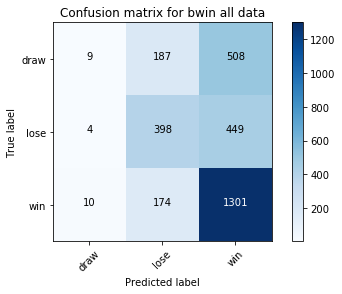

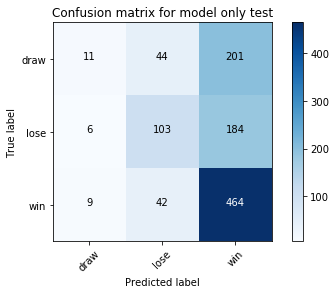

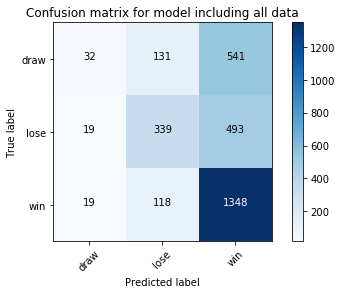

In [29]:
# Check accuracy for bwin and compare

# Model evaluation
# http://scikit-learn.org/stable/modules/model_evaluation.html

print('\nPrediction accuracy for BWIN betting house')
print('{:.2%}\n'.format(metrics.accuracy_score(target, bwin_target)))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(target, bwin_target)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['draw','lose','win'],
                      title='Confusion matrix for bwin all data')

# Compute confusion matrix
cnf2_matrix = confusion_matrix(y_test, lr_clf.predict(X_test))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf2_matrix, classes=['draw','lose','win'],
                      title='Confusion matrix for model only test')

# Compute confusion matrix
cnfall_matrix = confusion_matrix(target, lr_clf.predict(features))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnfall_matrix, classes=['draw','lose','win'],
                      title='Confusion matrix for model including all data')

plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(target, bwin_target, target_names=['draw', 'lose', 'win']))

print(classification_report(y_test, lr_clf.predict(X_test), target_names=['draw', 'lose', 'win']))

print(classification_report(target, lr_clf.predict(features), target_names=['draw', 'lose', 'win']))

In [ ]:
target